<a href="https://colab.research.google.com/github/ibrahim-syah/indonesian-distilbert-finetuned-squad/blob/main/notebook/Squad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2021 Rifky Bujana Bisri & Muhammad Fajrin Buyang Daffa

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Copyright 2023 Ibrahim Syah Qardhawi

Made some changes to make it easier to look at the plot and change the pretrained model to Indonesian DistilBERT base.

idk anything about licensing chatgpt told me to write it like this whatever

In [1]:
!pip install datasets evaluate
!pip install transformers -U
!pip install accelerate -U
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.0
    Uninstalling transformers-4.33.0:
      Successfully uninstalled transformers-4.33.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 74 not upgraded.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git config --global user.email "ibrahim.syah.q@gmail.com"
!git config --global user.name "ibrahim-syah"

In [3]:
import transformers

transformers.__version__

'4.33.2'

In [4]:
impossible_answer = True
model_checkpoint = "cahya/distilbert-base-indonesian"
batch_size = 16

# Runtime Settings

In [5]:
# !nvidia-smi

# Data Preparation

## Load Dataset

In [6]:
import json

#  # if using the qa-ind2 dataset in kaggle
dev_filename = "/kaggle/input/qa-ind2/dev-v2.0.json"
train_filename = "/kaggle/input/qa-ind2/train-v2.0.json"

# # otherwise, download them yourself
# !wget https://storage.depia.wiki/squad/tar/dev-v2.0.json
# !wget https://storage.depia.wiki/squad/tar/train-v2.0.json
# dev_filename = "dev-v2.0.json"
# train_filename = "train-v2.0.json"

# google colab default /content folder
# dev_filename = "/content/drive/MyDrive/dev-v2.0.json"
# train_filename = "/content/drive/MyDrive/train-v2.0.json"

with open(dev_filename) as f:
    dev = json.load(f)

with open(train_filename) as f:
    train = json.load(f)

🤗 actually provides the [squad_v2](https://huggingface.co/datasets/squad_v2) dataset that has been formatted for training but that dataset was for the original SQuAD2.0 whereas the dataset we will use is the [Translated SQuAD2.0](https://github.com/Wikidepia/indonesian_datasets/tree/master/question-answering/squad).

In [7]:
print("There are %s data in this split"%len(train["data"])) # number of different data titles

i = 3
title = train["data"][i]["title"]
paragraphs = train["data"][i]["paragraphs"]
print("The title for the data indexed at %s is %s"%(i, title))
print("Said data title has %s paragraph(s)"%(len(paragraphs)))
print("The first three paragraph is the following: ")
paragraphs[:3]

There are 442 data in this split
The title for the data indexed at 3 is IPod
Said data title has 60 paragraph(s)
The first three paragraph is the following: 


[{'context': 'iPod adalah garis pemutar media portabel dan komputer saku multiguna yang dirancang dan dipasarkan oleh Apple Inc. Baris pertama dirilis pada tanggal 23 Oktober 2001, sekitar 81⁄2 bulan setelah iTunes (versi Macintosh) dirilis. iPod rancangan ulang terbaru diumumkan pada tanggal 15 Juli 2015. Ada tiga versi iPod terkini: iPod Shuffle ultra kompact, iPod Nano yang padat dan Touch iPod layar sentuh.',
  'qas': [{'question': 'Perusahaan mana yang memproduksi iPod?',
    'answers': [{'text': 'Apple', 'answer_start': 104}],
    'id': '56cc55856d243a140015ef0a',
    'is_impossible': False},
   {'question': 'Kapan iPod asli dirilis?',
    'answers': [{'text': '23 Oktober 2001', 'answer_start': 150}],
    'id': '56cc55856d243a140015ef0b',
    'is_impossible': False},
   {'question': 'Berapa banyak jenis iPod yang tersedia saat ini?',
    'answers': [{'text': 'tiga', 'answer_start': 298}],
    'id': '56cc55856d243a140015ef0c',
    'is_impossible': False},
   {'question': 'Apa jeni

It's always a good idea to take a look at our data to get a feel of what they represent. If you compare this format with the finished one from 🤗 squad_v2 you will see that 🤗 squad_v2 pair together the question and answer along with the corresponding id, title, and context while removing everything else. Try looking at the dev split and see if you notice any difference ;).

Since the this raw dataset has a different format than what was expected by our training model (we'll use 🤗 AutoModelForQuestionAnswering)  we will need to format them so each pair of question and answer is an individual data.

In [8]:
def format(content):
    hf_data = []
    for data in content["data"]:
        title = data["title"]
        for paragraph in data["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                fill = {
                    "id":  qa["id"],
                    "title": title,
                    "context": context,
                    "question": qa["question"],
                    "answers": {"answer_start": [], "text": []}
                }
                if qa["is_impossible"]:
                    answers = qa["plausible_answers"]
                else:
                    answers = qa["answers"]
                for answer in answers:
                    fill["answers"]["answer_start"].append(answer["answer_start"])
                    fill["answers"]["text"].append(answer["text"])

                hf_data.append(fill)

    return hf_data

In [9]:
%%time
dev = format(dev)
train = format(train)

CPU times: user 990 ms, sys: 49.2 ms, total: 1.04 s
Wall time: 1.04 s


In [10]:
# # use small dataset for testing
# train = train[:1000]
# dev = dev[:100]
# len(train), len(dev)

In [11]:
from datasets import DatasetDict, Dataset
import pandas as pd

datasets = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(train)),
    'validation': Dataset.from_pandas(pd.DataFrame(dev))
})
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130318
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11858
    })
})

In [12]:
datasets['train']['id'][0]

'56be85543aeaaa14008c9063'

## Data Analyzation

In [13]:
import random
import numpy as np


def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame((np.asarray(dev)[picks]).tolist())

    df['answer_start'] = [i['answer_start'] for i in df['answers']]
    df['answer_text'] = [i['text'] for i in df['answers']]

    del df['answers']

    return df

We are creating this dataframe to make them easier to work with in data analyzation. For training, we will still be using the original 'datasets' DatasetDict.

In [14]:
from IPython.display import display, HTML

display(HTML(show_random_elements(dev).to_html()))

,id,title,context,question,answer_start,answer_text
0,5729ffda1d046914007796b1,Immune_system,"Memori aktif jangka panjang diperoleh berikut infeksi oleh aktivasi sel B dan T. Kekebalan aktif juga dapat dihasilkan secara buatan, melalui vaksinasi. Prinsip di balik vaksinasi (juga disebut imunisasi) adalah memperkenalkan antigen dari patogen untuk merangsang sistem kekebalan tubuh dan mengembangkan kekebalan tertentu terhadap patogen tertentu tanpa menyebabkan penyakit yang berhubungan dengan organisme itu. Reduksi yang disengaja dari respon kekebalan tubuh ini berhasil karena memanfaatkan spesifik alami sistem kekebalan tubuh, serta kesanggupannya. Dengan penyakit menular yang tersisa dari salah satu penyebab utama kematian dalam populasi manusia, vaksinasi menggambarkan manipulasi yang paling efektif dari sistem kekebalan tubuh yang telah dikembangkan umat manusia.","Dalam proses vaksinasi, apa yang diperkenalkan guna mengembangkan kekebalan tertentu?","[227, 227, 227]","[antigen dari patogen, antigen, antigen dari patogen]"
1,5725f2c838643c19005aceed,"Fresno,_California","Di bagian timur Fresno, Woodward Park didirikan oleh almarhum Ralph Woodward, penduduk Fresno yang lama. Ia mewariskan sebagian besar tanah miliknya pada tahun 1968 untuk menyediakan cagar alam regional dan suaka burung di Northeast Fresno. Taman itu terletak di tepi selatan Sungai San Joaquin antara Jalan Raya 41 dan Jalan Friant. Pada awal 235 hektar (0,95 kilometer2), ditambah dengan hektar tambahan yang diperoleh belakangan oleh Kota itu, taman ini menghasilkan lahan seluas 1,2 kilometer. Sekarang, yang sarat dengan fasilitas, Woodward Park adalah satu - satunya Taman Regional seukurannya di Lembah Tengah. Di sudut tenggara taman ini terdapat banyak spesies burung yang menawarkan kesempatan yang sangat bagus untuk menonton burung. Taman ini memiliki amfiteater multi-guna yang terletak di tempat duduk hingga 2.500 orang, taman asli Jepang, taman anjing berpagar, jalur berkuda berjarak 3 mil, latihan par course, tiga taman bermain anak-anak, danau, 3 kolam kecil, 7 area piknik dan delapan kilometer jalur dengan berbagai tujuan yang merupakan bagian dari Sungai San Joaquin, Lewis Parkway S. Eaton Trail. Apabila selesai, sistem trail Lewis S. Eaton akan menempuh 35 kilometer di antara Jalan Raya 99 dan Bendungan Friant. Banyak meja piknik di taman ini menjadi tempat yang bagus untuk piknik dan nyaman untuk melarikan diri dari kehidupan kota. Amfeteater taman itu direnovasi pada tahun 2010, dan telah menjadi tuan rumah pertunjukan dengan tindakan seperti Deftones, Tech N9ne, dan Sevendust serta banyak orang lainnya. Taman ini buka bulan April sampai Oktober, jam 6 pagi sampai jam 10 malam dan November sampai Maret, 6 pagi sampai pukul 7 sore. Woodward Park adalah rumah bagi CIFaneshCalifornia Interscholastic Federation) State Championship cross country bertemu, yang berlangsung pada akhir November. Ini juga adalah rumah Festival Shakespeare Woodward yang mulai pertunjukan di taman pada tahun 2005.",Siapa yang mendirikan Woodward Park?,"[62, 62, 62]","[Ralph Woodward, Ralph Woodward, Ralph Woodward]"
2,56e1e9dfe3433e14004231fe,Computational_complexity_theory,"Masalah isomorfisme grafik adalah masalah komputasi untuk menentukan apakah dua grafik yang terbatas adalah isomorfik. Sebuah masalah penting yang belum terpecahkan dalam teori kompleksitas adalah apakah masalah isomorfisme grafik berada dalam P, NP-lengkap, atau NP-intermediate. Jawabannya tidak diketahui, tetapi diyakini bahwa masalahnya setidaknya tidak lengkap. Jika grafik isomorfisme lengkap, hierarki waktu polinomial runtuh ke tingkat kedua. Karena secara luas diyakini bahwa hierarki polinomial tidak runtuh ke tingkat terbatas, diyakini bahwa grafik isomorfisme tidak lengkap. Algoritma terbaik untuk masalah ini, karena LaszIo Babai dan Eugene Luks telah berjalan waktu 2Oón log Allahn))))) untuk grafik dengan titik n.",Apa hirarki terbatas menyiratkan bahwa masalah isomorfisme grafik adalah NP-lengka

In [15]:
train_df = pd.DataFrame(train)

train_df['answer_start'] = [i['answer_start'] for i in train_df['answers']]
train_df['answer_text'] = [i['text'] for i in train_df['answers']]

del train_df['answers']

In [16]:
dev_df = pd.DataFrame(dev)

dev_df['answer_start'] = [i['answer_start'] for i in dev_df['answers']]
dev_df['answer_text'] = [i['text'] for i in dev_df['answers']]

del dev_df['answers']

Let's see how the length of each context, question, and answer for both of these splits.

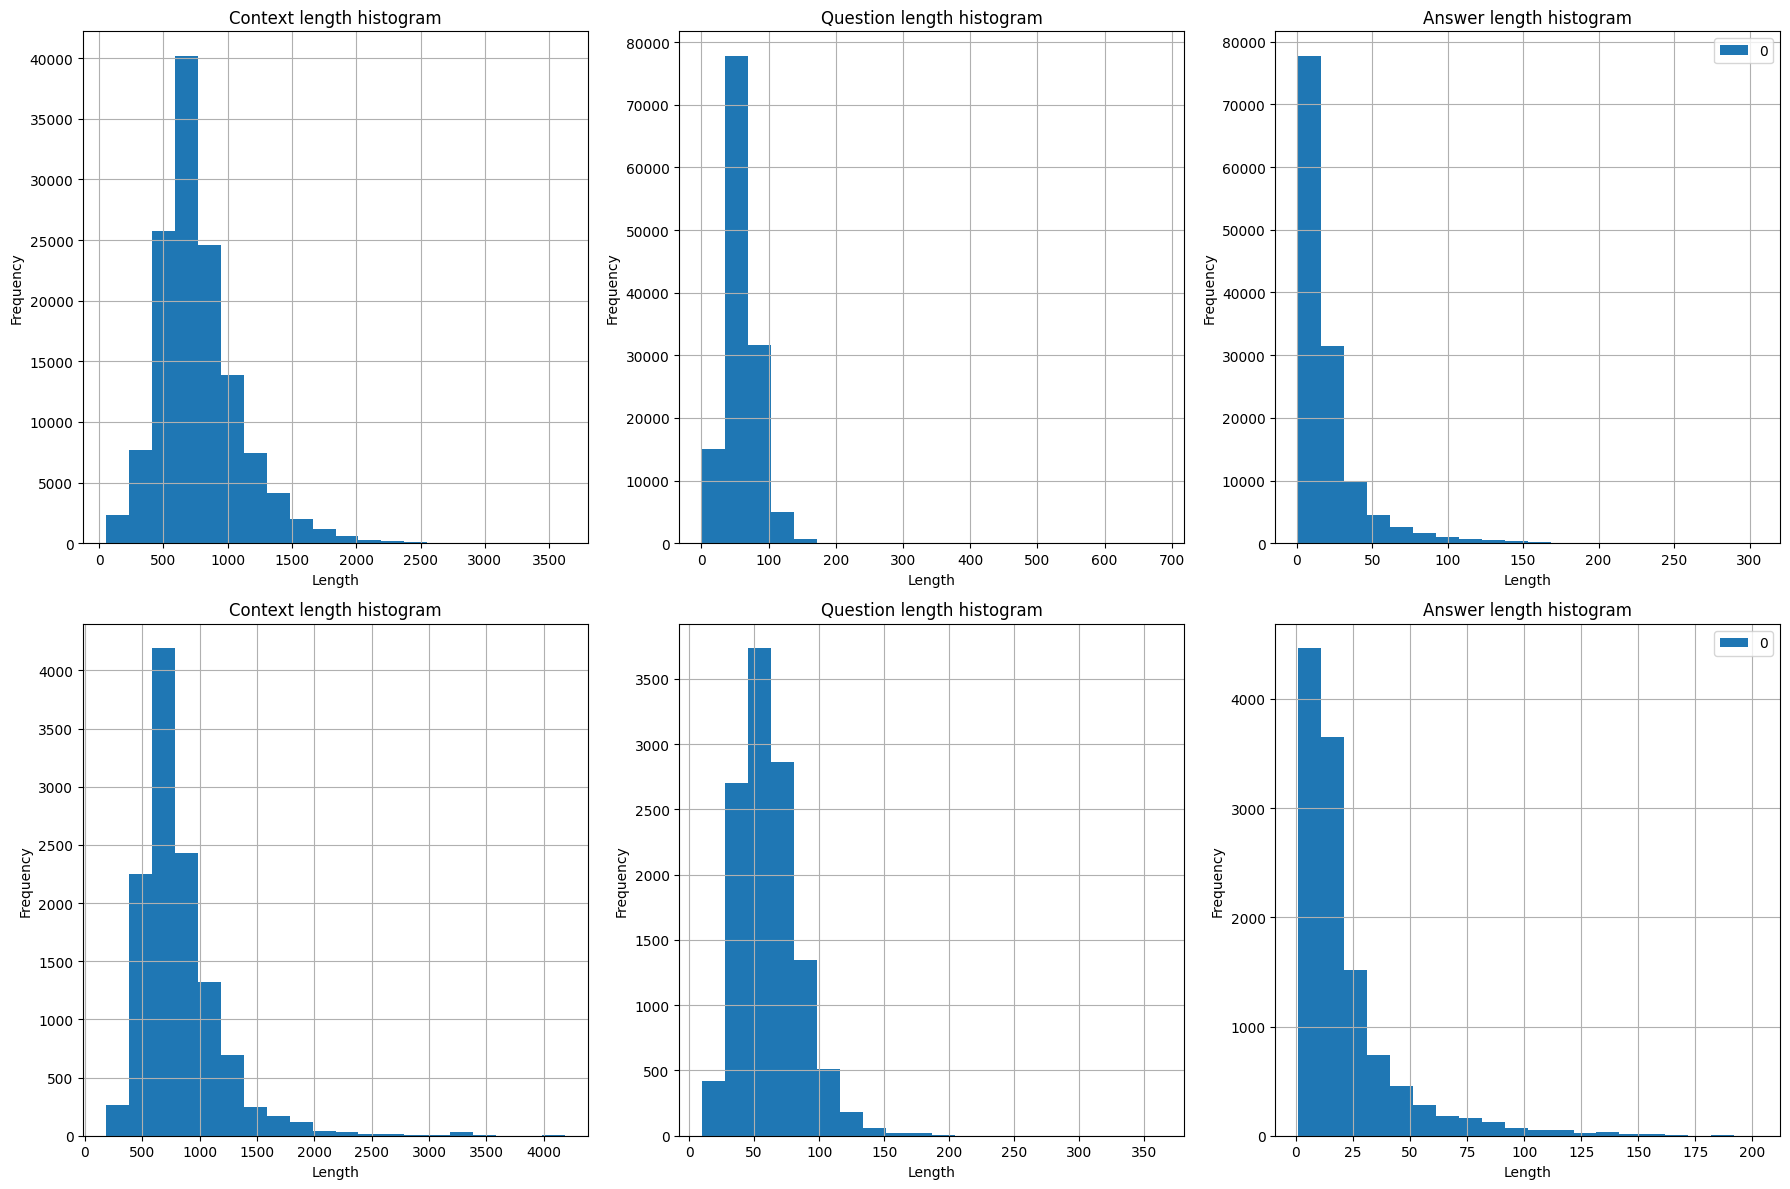

In [17]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Define the datasets and their corresponding titles
plot_datasets = [(train_df, "Training Dataset"), (dev_df, "Validation Dataset")]

# Define the column names and corresponding titles
columns = [('context', "Context length histogram"),
           ('question', "Question length histogram"),
           ('answer_text', "Answer length histogram")]

# Loop through datasets and columns to plot histograms
for i, (dataset, dataset_title) in enumerate(plot_datasets):
    for j, (column, title) in enumerate(columns):
        ax = axes[i, j]
        if column == "answer_text":
            pd.DataFrame([len(n[0]) for n in dataset['answer_text']]).plot.hist(title=title, bins=20, ax=ax, grid=True)
        else:
            dataset[column].apply(len).plot.hist(title=title, bins=20, ax=ax, grid=True)
        ax.set_xlabel("Length")
        ax.set_ylabel("Frequency")
        ax.grid(True)
        if j == 0:
            ax.set_ylabel("Frequency")
        if i == 1:
            ax.set_xlabel("Length")
        if i == 0:
            ax.set_title(title)
#         if j == 0:
#             ax.set_title(dataset_title)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

It seems that the contexts, questions, and answers within the validation set (bottom) are shorter than their training counterpart, or maybe that's just because they lack more data.

## Text Preprocessing

The 🤗 [docs](https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt#processing-the-training-data) has an excellent piece on this particular preprocessing part. In short, we will split long contexts into multiple features. Here is an example:

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [19]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [20]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting is needed.

In [21]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

In [22]:
len(tokenizer(example["question"], example["context"])["input_ids"])

402

In [23]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

In [24]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [25]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 156]

In [26]:
for x in tokenized_example["input_ids"][:]:
    print(tokenizer.decode(x))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CLS] beyonce menikah tahun 2008 dengan siapa? [SEP] pada tanggal 4 april 2008, beyonce menikahi jay z. dia membeberkan pernikahan mereka di depan umum dalam video montase di pesta mendengarkan album studio ketiganya, aku... sasha fierce, di sony club manhattan pada 22 oktober 2008. aku... sasha fierce dibebaskan pada tanggal 18 november 2008 di amerika serikat. album ini secara resmi memperkenalkan alter ego beyonce sasha fierce, yang dibuat pada tahun 2003 single " crazy in love ", menjual 482. 000 salinan pada minggu pertamanya, debutnya di atas billboard 200, dan memberikan beyonce album nomor satu ketiga berturut - turut di as. album menampilkan lagu nomor satu " single ladies ( put a ring on it ) " dan top - lima lagu " if i were a boy " dan " halo. " mencapai pencapaiannya menjadi 100 wanita lajang terpanjang dalam karirnya, " halo " sukses di amerika serikat membantu beyonce mencapai lebih dari sepuluh single dalam daftar daripada wanita lain pada tahun 2000 - an. ini juga term

Compared to the original:

In [27]:
example

{'id': '56be95823aeaaa14008c910c',
 'title': 'Beyoncé',
 'context': 'Pada tanggal 4 April 2008, Beyoncé menikahi Jay Z. Dia membeberkan pernikahan mereka di depan umum dalam video montase di pesta mendengarkan album studio ketiganya, aku... Sasha Fierce, di Sony Club Manhattan pada 22 Oktober 2008. Aku... Sasha Fierce dibebaskan pada tanggal 18 November 2008 di Amerika Serikat. Album ini secara resmi memperkenalkan alter ego Beyoncé Sasha Fierce, yang dibuat pada tahun 2003 single "Crazy in Love", menjual 482.000 salinan pada minggu pertamanya, debutnya di atas Billboard 200, dan memberikan Beyonce album nomor satu ketiga berturut-turut di AS. Album menampilkan lagu nomor satu "Single Ladies (Put a Ring on It)" dan top-lima lagu "If I Were a Boy" dan "Halo." Mencapai pencapaiannya menjadi 100 wanita lajang terpanjang dalam karirnya, "Halo" sukses di Amerika Serikat membantu Beyoncé mencapai lebih dari sepuluh single dalam daftar daripada wanita lain pada tahun 2000-an. Ini juga termasu

In [28]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][1][:100])

[(0, 0), (0, 7), (8, 15), (16, 21), (22, 26), (27, 33), (34, 39), (39, 40), (0, 0), (1111, 1112), (1112, 1116), (1116, 1118), (1118, 1120), (1121, 1125), (1126, 1133), (1133, 1134), (1135, 1139), (1140, 1145), (1146, 1154), (1155, 1162), (1163, 1170), (1171, 1175), (1175, 1176), (1177, 1182), (1183, 1186), (1187, 1198), (1199, 1207), (1208, 1219), (1219, 1220), (1221, 1229), (1230, 1234), (1235, 1240), (1241, 1245), (1246, 1257), (1258, 1263), (1264, 1269), (1270, 1273), (1274, 1278), (1278, 1279), (1280, 1291), (1292, 1295), (1295, 1296), (1297, 1307), (1308, 1312), (1312, 1313), (1314, 1317), (1318, 1321), (1322, 1328), (1329, 1333), (1333, 1334), (1335, 1339), (1340, 1351), (1352, 1357), (1358, 1363), (1364, 1367), (1368, 1372), (1372, 1373), (1374, 1379), (1380, 1383), (1384, 1397), (1398, 1403), (1404, 1412), (1413, 1424), (1424, 1425), (1426, 1434), (1435, 1446), (1447, 1451), (1452, 1460), (1461, 1466), (1467, 1469), (1470, 1473), (1474, 1478), (1478, 1479), (1480, 1489), (1489,

In [29]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

beyonce Beyonce


Because of the feature split, we need to be careful when looking if the answer is within the context fully or not. We can use sequence_ids() to help us.

In [30]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Let's see an example where we tokenize four examples with max_length of 100 and a stride of 50 so it will produce more features (more likely for a feature to not contain our answer).

In [31]:
inputs = tokenizer(
    datasets["train"][2:6]["question"],
    datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 12 features.
Here is where each comes from: [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3].


In [32]:
answers = datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([0, 95, 60, 52, 13, 0, 71, 31, 0, 88, 51, 14],
 [0, 95, 60, 54, 15, 0, 74, 34, 0, 91, 54, 17])

Which means we didn't find the answer in the 0th and the 5th feature so we just denote that with the (0, 0) tuple or [CLS] token.

In [33]:
idx = 1
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: 2003, labels give: 2003


In [34]:
idx = 5
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])
decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")
print("decoded example: ",decoded_example)

Theoretical answer: Houston, Texas, labels give: [CLS]
decoded example:  [CLS] di kota dan negara mana beyonce tumbuh? [SEP] s child. dikelola oleh ayahnya, mathew knowles, kelompok itu menjadi salah satu kelompok gadis terlaris di dunia sepanjang masa. hiatus mereka melihat rilis album debut beyonce, berbahaya dalam cinta ( 2003 ), yang didirikan sebagai artis solo di seluruh dunia, memperoleh lima grammy awards dan menampilkan billboard hot 100 nomor satu " gila cinta " dan " baby boy. " [SEP]


Now we can start preprocessing the training set.

In [35]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace with strip()
    questions = [q.strip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = inputs.pop("offset_mapping")
    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0) or [CLS]
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [39]:
tokenized_datasets = datasets.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=datasets["train"].column_names,
)
tokenized_datasets

  0%|          | 0/131 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 131170
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 12071
    })
})

Now we can get to fine-tuning

## Fine Tuning Model

In [37]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    "distilbert-indonesian-squad",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

In [41]:
from transformers import default_data_collator

data_collator = default_data_collator

In [42]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [43]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,1.851300,1.977660
2,1.570200,1.962839
3,1.376300,2.006688


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=12300, training_loss=1.702938969309737, metrics={'train_runtime': 8854.4977, 'train_samples_per_second': 44.442, 'train_steps_per_second': 1.389, 'total_flos': 3.855997604519424e+16, 'train_loss': 1.702938969309737, 'epoch': 3.0})

In [44]:
trainer.save_model("distilbert-indonesian-squad")
trainer.push_to_hub(commit_message="Training complete")

'https://huggingface.co/boimbukanbaim/distilbert-indonesian-squad/tree/main/'

## SQuADv2.0 Evaluation (WIP)

In [45]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits', 'hidden_states'])

In [46]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([32, 384]), torch.Size([32, 384]))

In [47]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 47,  30,  75,  81, 150,  12,  41,  96, 139, 183, 181,  51,  15,  33,
         111, 111,  36,  19,  93,  19,  93,  52,  80, 137,  14,  63,  87, 113,
          15,  43, 119,  26], device='cuda:0'),
 tensor([ 47,  37,  79,  82, 150,  13,  41,  98, 144, 187, 185,  52,  22,  33,
          31,   9, 223,  23,  95,  30,  95,  52,  85, 138,  17,  72,  88, 119,
          16,  46, 147,  27], device='cuda:0'))

In [48]:
n_best_size = 20

In [49]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [50]:
pad_on_right = True

In [51]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples


In [52]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)

  0%|          | 0/12 [00:00<?, ?ba/s]

In [74]:
import os
torch.cuda.empty_cache() 

In [75]:
from transformers import AutoModelForQuestionAnswering, AutoModel, TrainingArguments, Trainer

trained_checkpoint = "boimbukanbaim/distilbert-indonesian-squad"
model = AutoModel.from_pretrained(trained_checkpoint)

In [76]:
from transformers import TrainingArguments, Trainer

batch_size = 1

args = TrainingArguments(
    "distilbert-indonesian-squad",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
#     push_to_hub=True,
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [77]:
# fix the out of memory error
raw_predictions = trainer.predict(validation_features)

OutOfMemoryError: CUDA out of memory. Tried to allocate 270.00 MiB (GPU 0; 14.76 GiB total capacity; 12.70 GiB already allocated; 265.75 MiB free; 13.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [ ]:
max_answer_length = 30

In [ ]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

In [ ]:
valid_answers[5]

In [ ]:
datasets["validation"][1231]

In [ ]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not impossible_answer:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [ ]:
final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

In [ ]:
def print_answer(id):
    text = [i for i in datasets['validation'] if i['id'] == id][0]
    print(f"Text: {text['context']}")
    print(f"Question: {text['question']}")
    print(f"Answer: {final_predictions[id]}")

In [ ]:
print_answer('5ad39d53604f3c001a3fe8d1')

In [ ]:
metric = load_metric("squad_v2" if impossible_answer else "squad")

In [ ]:
formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

## Using the Model with 🤗 Pipeline

In [78]:
from transformers import pipeline

model_checkpoint = "boimbukanbaim/distilbert-indonesian-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
Dalam matematika, turunan atau derivatif dari sebuah fungsi adalah cara mengukur sensitivitas perubahan nilai fungsi terhadap perubahan pada nilai variabelnya. Sebagai contoh, turunan dari posisi sebuah benda bergerak terhadap waktu mengukur kecepatan benda bergerak ketika waktu berjalan. Turunan adalah alat penting dalam kalkulus.

Turunan sebuah fungsi satu variabel di suatu titik, jika itu ada, adalah kemiringan dari garis singgung dari grafik fungsi di titik tersebut. Garis singgung adalah hampiran (aproksimasi) linear terbaik dari fungsi di sekitar titik tersebut. Konsep turunan dapat diperumum untuk fungsi multivariabel. Dalam perumuman ini, turunan dianggap sebagai transformasi linear, dengan translasi yang sesuai, menghasilkan hampiran linear dari grafik fungsi multivariabel tersebut. Matriks Jacobi adalah matriks yang merepresentasikan transformasi linear terhadap suatu basis yang ditentukan. Matriks ini dapat ditentukan dengan turunan parsial dari variabel-variabel independen. Pada fungsi multivariabel bernilai real, matriks Jacobi tereduksi menjadi vektor gradien.

Proses menemukan turunan disebut diferensiasi. Kebalikan proses ini disebut dengan antiturunan. Teorema fundamental kalkulus menyatakan hubungan diferensiasi dengan integrasi. Turunan dan integral adalah dua operasi dasar dalam kalkulus satu-variabel.

Konsep turunan fungsi yang universal banyak digunakan dalam berbagai cabang matematika maupun bidang ilmu yang lain. Dalam bidang ekonomi, turunan digunakan untuk menghitung biaya marginal, total penerimaan, dan biaya produksi. Bidang biologi menggunakan turunan untuk menghitung laju pertumbuhan mikroorganisme, dalam bidang fisika untuk menghitung kepadatan kawat, dalam bidang kimia untuk menghitung laju pemisahan, dalam bidang geografi untuk menghitung laju pertumbuhan penduduk, dan masih banyak lagi.
"""
question = "Apa itu derivatif?"
question_answerer(question=question, context=context)

{'score': 0.09063782542943954,
 'start': 61,
 'end': 159,
 'answer': 'adalah cara mengukur sensitivitas perubahan nilai fungsi terhadap perubahan pada nilai variabelnya'}